## Train model for all glaciers, blocking by glacier


In [23]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold


In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


Text(0.5, 0, 'glacier id')

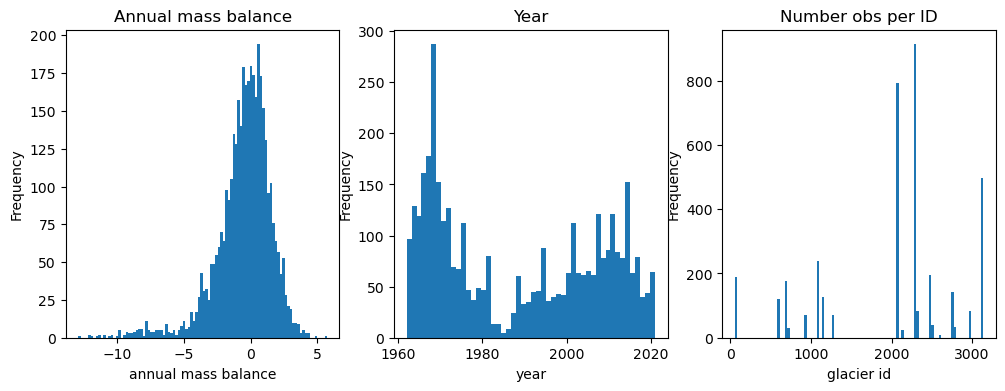

In [3]:
# Plot dataset distributions

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=False)
glacier_data_all['balance_netto'].plot.hist(bins=100, ax=ax1)
ax1.set_title('Annual mass balance')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('annual mass balance')

glacier_data_all['year'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Year')
ax2.set_xlabel('year')

glacier_data_all['BREID'].plot.hist(bins=100, ax=ax3)
ax3.set_title('Number obs per ID')
ax3.set_xlabel('glacier id')

In [3]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

Train mass balance: mean -0.35130788897005116, min -12.9, max 5.72.
Test mass balance: mean -0.9395476839237057, min -6.3, max 4.1.
Train altitude: mean 1359.92319211103, min 190.0, max 2212.0.
Test altitude: mean 1252.8973660308811, min 390.0, max 2105.0.
Train mean temp: mean -1.7672880851238233, min -7.492487335205055, max 3.914905802408896.
Test mean temp: mean -1.3522719052644447, min -7.176125590006507, max 3.888141886393271.
Train prec sum: mean 0.0673273819015023, min 0.026136178523301197, max 0.132155250757932.
Test prec sum: mean 0.06271467678211604, min 0.026136178523301197, max 0.123711260966956.


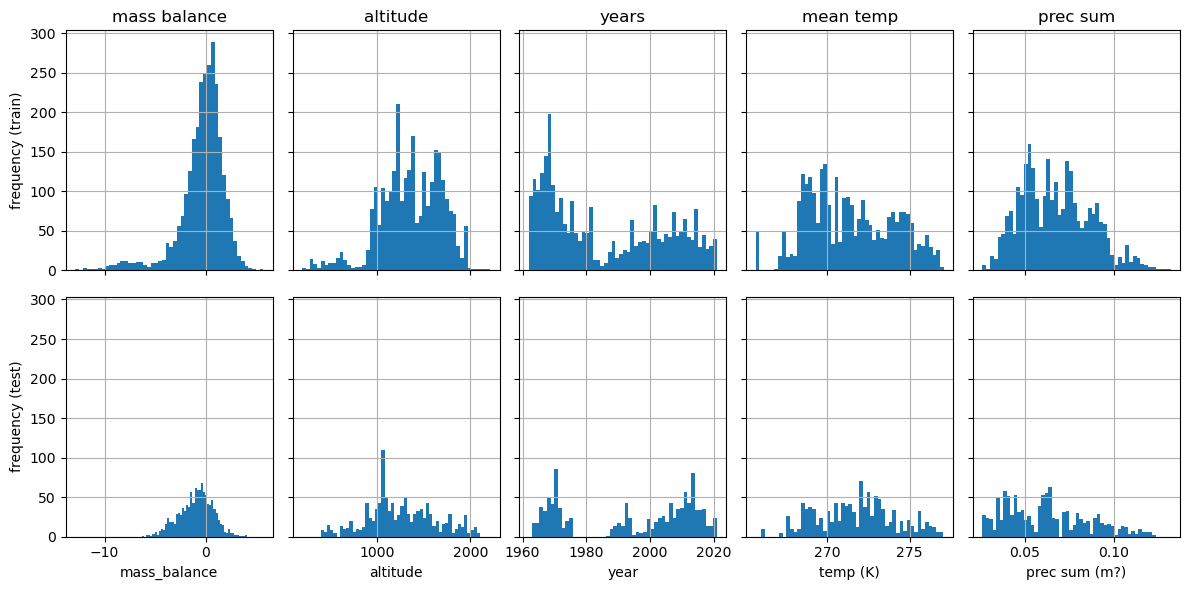

In [9]:
# Number of measurements by topography
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']

f, ax = plt.subplots(2, 5, figsize=(12,6), sharey=True, sharex='col')
df_train['balance_netto'].plot.hist(bins=50, ax=ax[0,0])
ax[0,0].set_title('mass balance')
ax[0,0].set_ylabel('frequency (train)')
df_train['altitude'].plot.hist(bins=50, ax=ax[0,1])
ax[0,1].set_title('altitude')
df_train['year'].plot.hist(bins=50, ax=ax[0,2])
ax[0,2].set_title('years')
df_train[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[0,3])
ax[0,3].set_title('mean temp')
df_train[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[0,4])
ax[0,4].set_title('prec sum')

df_test['balance_netto'].plot.hist(bins=50, ax=ax[1,0])
ax[1,0].set_ylabel('frequency (test)')
ax[1,0].set_xlabel('mass_balance')
df_test['altitude'].plot.hist(bins=50, ax=ax[1,1])
ax[1,1].set_xlabel('altitude')
df_test['year'].plot.hist(bins=50, ax=ax[1,2])
ax[1,2].set_xlabel('year')
df_test[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[1,3])
ax[1,3].set_xlabel('temp (K)')
df_test[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[1,4])
ax[1,4].set_xlabel('prec sum (m?)')

for row in ax:
    for a in row:
        a.grid()

plt.tight_layout()

T_0 = 273.15
print(f"Train mass balance: mean {df_train['balance_netto'].mean()}, min {df_train['balance_netto'].min()}, max {df_train['balance_netto'].max()}.")
print(f"Test mass balance: mean {df_test['balance_netto'].mean()}, min {df_test['balance_netto'].min()}, max {df_test['balance_netto'].max()}.")
print(f"Train altitude: mean {df_train['altitude'].mean()}, min {df_train['altitude'].min()}, max {df_train['altitude'].max()}.")
print(f"Test altitude: mean {df_test['altitude'].mean()}, min {df_test['altitude'].min()}, max {df_test['altitude'].max()}.")
print(f"Train mean temp: mean {df_train[temp_cols].mean().mean()-T_0}, min {df_train[temp_cols].mean(axis=1).min()-T_0}, max {df_train[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Test mean temp: mean {df_test[temp_cols].mean().mean()-T_0}, min {df_test[temp_cols].mean(axis=1).min()-T_0}, max {df_test[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Train prec sum: mean {df_train[prec_cols].sum(axis=1).mean()}, min {df_train[prec_cols].sum(axis=1).min()}, max {df_train[prec_cols].sum(axis=1).max()}.")
print(f"Test prec sum: mean {df_test[prec_cols].sum(axis=1).mean()}, min {df_test[prec_cols].sum(axis=1).min()}, max {df_test[prec_cols].sum(axis=1).max()}.")

### Training with only temperature, precipitation and topographical features

In [28]:
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)
df_train_y = select_variables(df_train, label_cols)
df_test_X = select_variables(df_test, base_cols, temp_cols, prec_cols)
df_test_y = select_variables(df_test, label_cols)

# 1409 for training (19 glaciers), 323 for testing (12 glaciers)
X_train, y_train = df_train_X.values, df_train_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [29]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [30]:
df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

gp_s = np.array(df_train_s['BREID'].values)

In [31]:
# Use five folds
group_kf = GroupKFold(n_splits=5)
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [32]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.712346463319846
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Cross validation scores per fold:  [-1.04266768 -2.18351812 -2.07217911 -0.75626956 -2.50709785]
Mean cross validation score:  -1.712346463319846
Standard deviation:  0.6849328059931279


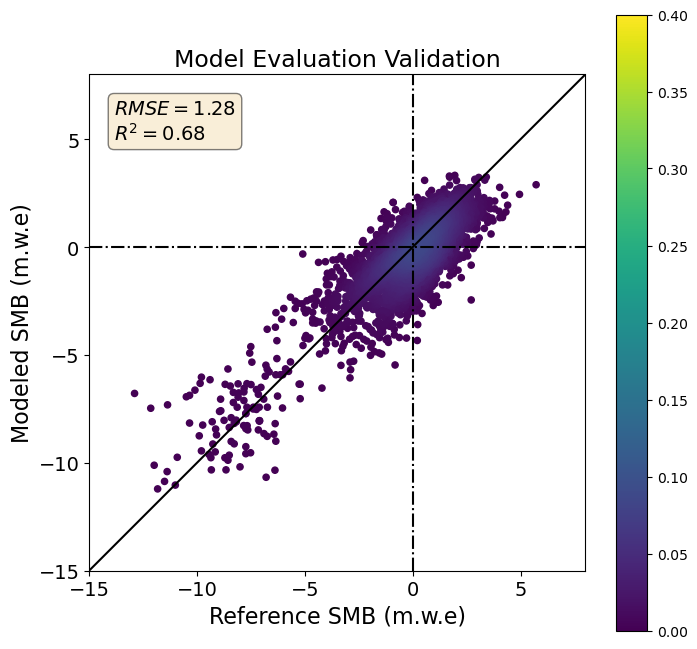

In [33]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

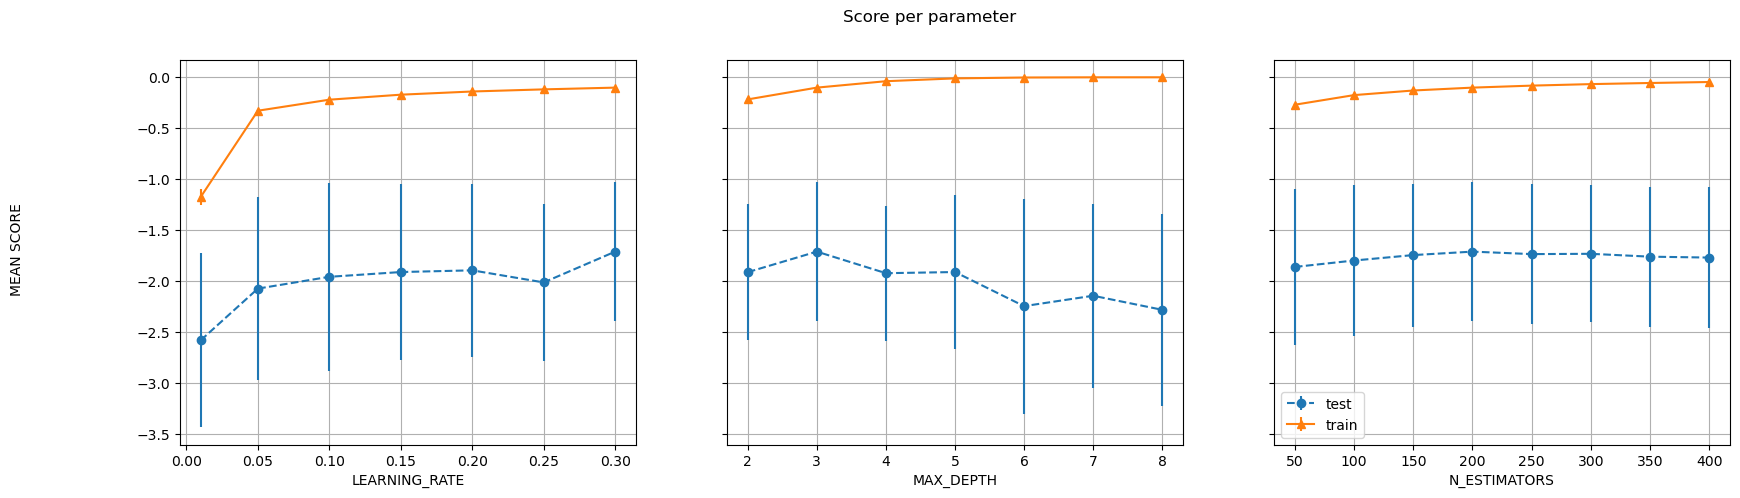

In [34]:
plot_gsearch_results(cv_grid)

In [35]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_temp_prec.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_temp_prec.pkl']

## Training with all climate variables

In [4]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [5]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X_s = df_train.drop(drop_cols, axis=1)
df_train_y_s = df_train[['balance_netto']]

#df_test_X = df_test.drop(drop_cols, axis=1)
#df_test_y = df_test[['balance_netto']]

In [6]:
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get shuffled glacier ids
gp_s = np.array(df_train_s['BREID'].values)

In [7]:
# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split dataset into groups based on shuffled glacier ids.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [8]:
# View order of sorted glaciers
df_gp_s = pd.DataFrame(gp_s)
df_gp_s[0].unique()

array([2078, 3128, 2297, 1144, 2474, 1094, 3129,  675, 2514, 3137, 3126,
        596, 3133, 2968, 2772, 2743, 1092, 2148, 3138, 2597], dtype=int64)

In [67]:
# X_train_s.shape is 2738
# gp_s.shape is 2738
# splits_s 0 is 1825 train, 913 test (Nigardsbreen as test)
# splits_s 1 is 2108 train, 630 test
# splits_s 2 is 2337 train, 401 test
# splits_s 3 is 2343 train, 395 test
# splits_s 4 is 2339 train, 399 test
# Sum of test obs: 913+630+401+395+399=2738

In [9]:
print('Train, fold 1: ', np.unique(gp_s[splits_s[0][0]]))
print('Test, fold 1: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[1][0]]))
print('Test, fold 2: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[2][0]]))
print('Test, fold 3: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[3][0]]))
print('Test, fold 4: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 5: ', np.unique(gp_s[splits_s[4][0]]))
print('Test, fold 5: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 1:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Test, fold 1:  [2297]
Train, fold 2:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Test, fold 2:  [2078]
Train, fold 3:  [ 596  675 1144 2078 2148 2297 2474 2514 2597 2743 3126 3128 3129 3137]
Test, fold 3:  [1092 1094 2772 2968 3133 3138]
Train, fold 4:  [ 596 1092 1094 1144 2078 2148 2297 2514 2772 2968 3126 3128 3133 3138]
Test, fold 4:  [ 675 2474 2597 2743 3129 3137]
Train, fold 5:  [ 675 1092 1094 2078 2297 2474 2597 2743 2772 2968 3129 3133 3137 3138]
Test, fold 5:  [ 596 1144 2148 2514 3126 3128]


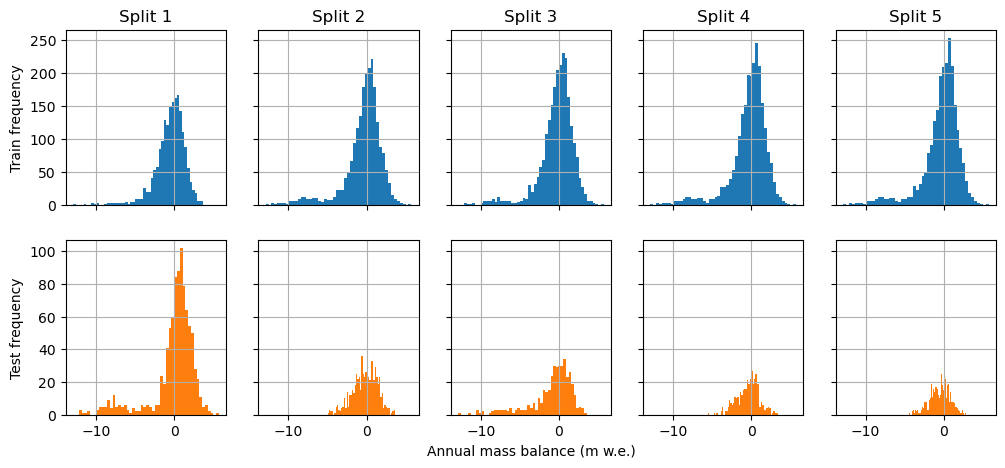

In [10]:
j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    df_train_s.iloc[splits_s[i][0]].balance_netto.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train_s.iloc[splits_s[i][1]].balance_netto.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Test frequency')
ax[1,2].set_xlabel('Annual mass balance (m w.e.)')
    
for row in ax:
    for a in row:
        a.grid()

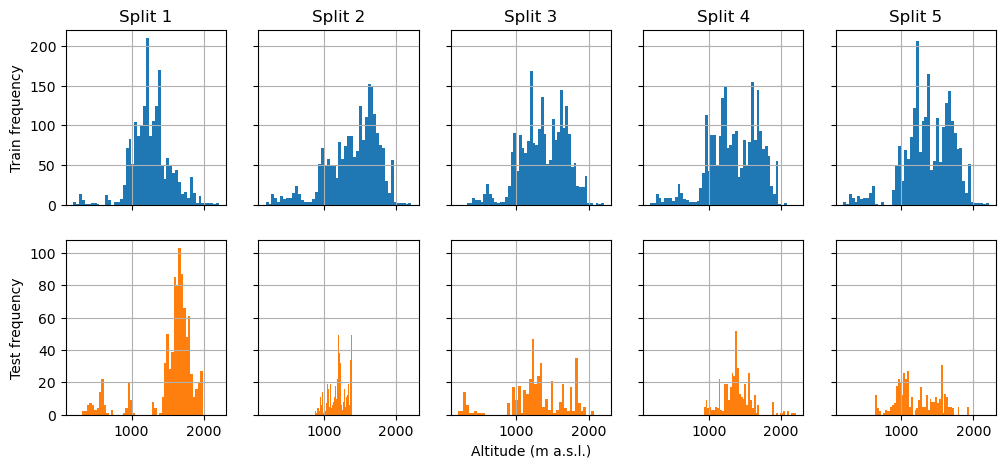

In [11]:
j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    df_train_s.iloc[splits_s[i][0]].altitude.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train_s.iloc[splits_s[i][1]].altitude.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Test frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

In [12]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.360476300498321
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-0.39687    -0.43001743 -0.28337383 -0.31460083 -0.37751942]
Mean cross validation score:  -0.360476300498321
Standard deviation:  0.05385218323480411


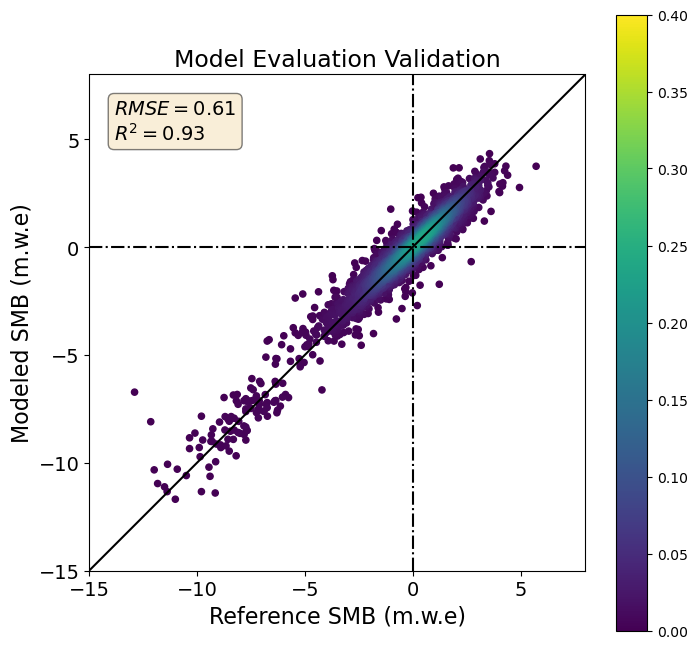

In [13]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

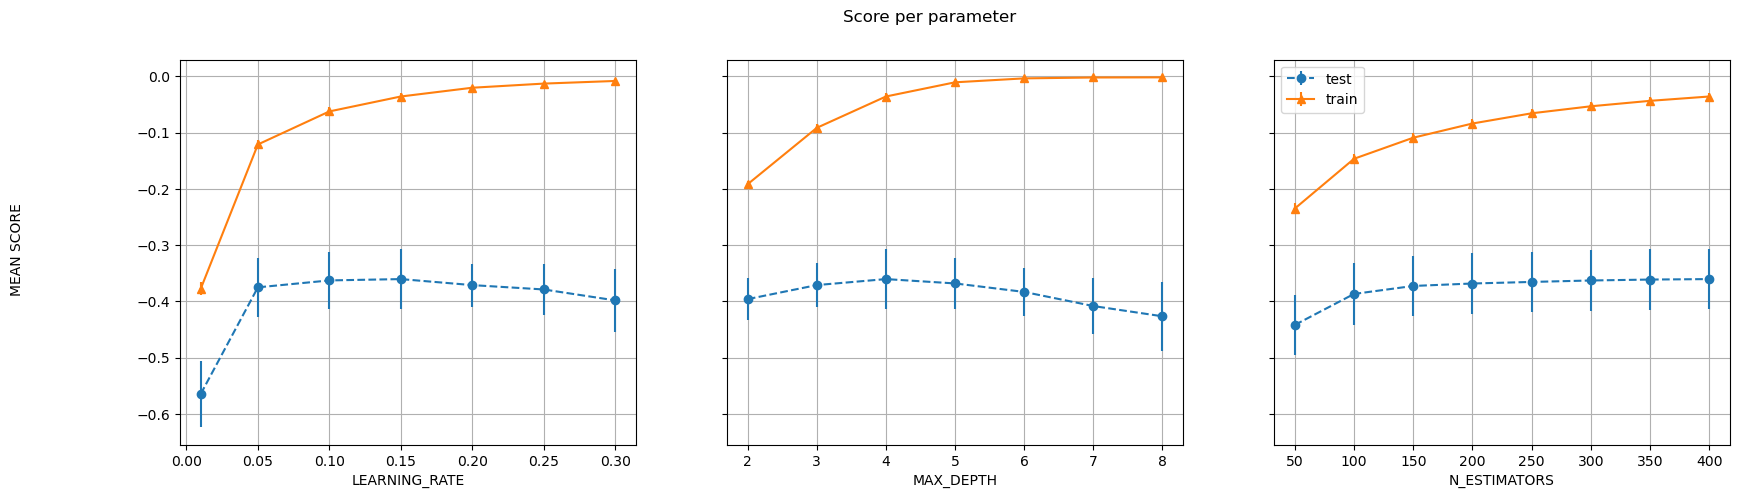

In [14]:
plot_gsearch_results(cv_grid)

In [15]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_all_climate.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_all_climate.pkl']

In [18]:
#test = joblib.load('Models/cv_block_glacier_5fold_all_climate.pkl')
# fitted_model = xgb.XGBRegressor(learning_rate = test.best_params_['learning_rate'], 
#                                 n_estimators = test.best_params_['n_estimators'],
#                                 max_depth = test.best_params_['max_depth'])

In [16]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

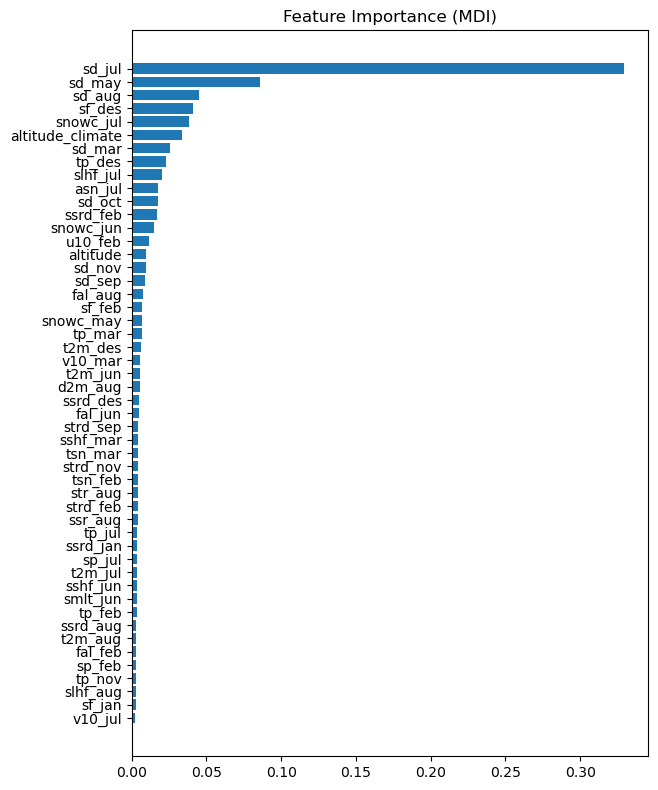

In [17]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [19]:
# Performance with fewer trees
#best_model_few_trees = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [26]:
model_fewer_trees = xgb.XGBRegressor(learning_rate = cv_grid.best_params_['learning_rate'], 
                                     n_estimators = 50,
                                     max_depth = cv_grid.best_params_['max_depth'])

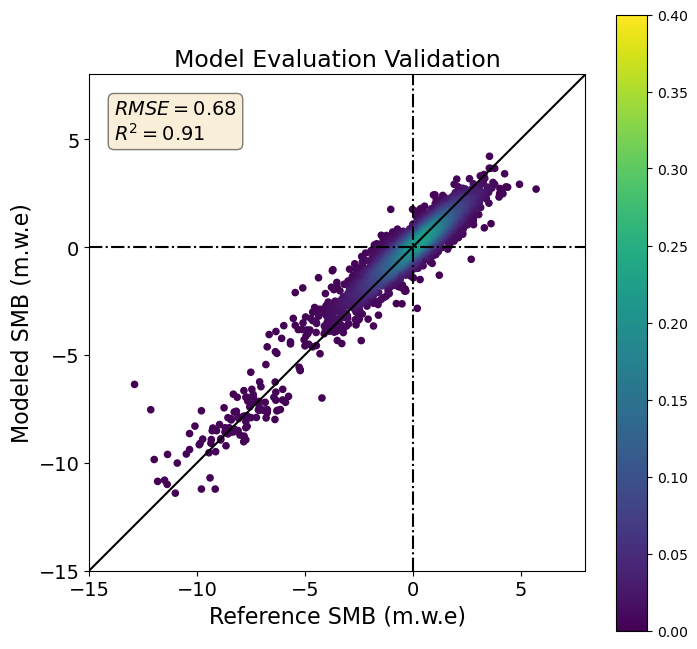

In [27]:
plot_prediction_per_fold(X_train_s, y_train_s, model_fewer_trees, splits_s)
